## Notebook for creating Simulation 3

See Section 6.3 of Susobhanan+ 2024.

In [31]:
from pint.models import get_model, get_model_and_toas
from pint.simulation import make_fake_toas_fromtim
from pint.logging import setup as setup_log
from pint.utils import wavex_setup, plrednoise_from_wavex, pldmnoise_from_dmwavex
from pint.fitter import WLSFitter

from io import StringIO
import numpy as np
import astropy.units as u
from copy import deepcopy
import corner

from joblib import Parallel, delayed

from matplotlib import pyplot as plt

In [2]:
setup_log(level="WARNING")

1

In [3]:
par_sim = """
    PSR           SIM3
    RAJ           05:00:00     1
    DECJ          15:00:00     1
    PEPOCH        55000
    F0            100          1
    F1            -1e-15       1 
    PHOFF         0            1
    DM            15           1
    DM1           0            1
    DM2           0            1  
    TNREDAMP      -13
    TNREDGAM      3.5
    TNREDC        30
    TNDMAMP       -13.5
    TNDMGAM       4
    TNDMC         30
    TZRMJD        55000
    TZRFRQ        1400 
    TZRSITE       gbt
    UNITS         TDB
    EPHEM         DE440
    CLOCK         TT(BIPM2019)
"""

In [11]:
m0 = get_model(StringIO(par_sim))

In [12]:
nharm_opt_dm, nharm_opt_arn = 5, 7

In [13]:
m1, t = get_model_and_toas("sim5.wx.par", "sim5.tim")

In [14]:
Tspan = t.get_mjds().max() - t.get_mjds().min()

idxs = m1.components["WaveX"].get_indices()
for idx in reversed(idxs):
    if idx > nharm_opt_arn:
        m1.components["WaveX"].remove_wavex_component(idx)

idxs = m1.components["DMWaveX"].get_indices()
for idx in reversed(idxs):
    if idx > nharm_opt_dm:
        m1.components["DMWaveX"].remove_dmwavex_component(idx)

ftr = WLSFitter(t, m1)
ftr.fit_toas(maxiter=5)

2472.2776791404060006

In [15]:
print(ftr.model)

# Created: 2024-05-31T11:18:25.955056
# PINT_version: 1.0+232.g3fe7a43e
# User: Abhimanyu Susobhanan (abhimanyu)
# Host: abhimanyu-HP-Envy-x360-2-in-1-Laptop-15-fh0xxx
# OS: Linux-6.5.0-35-generic-x86_64-with-glibc2.35
# Python: 3.9.19 (main, May  6 2024, 19:43:03) 
# [GCC 11.2.0]
# Format: pint
PSR                                  SIM3
EPHEM                               DE440
CLOCK                        TT(BIPM2019)
UNITS                                 TDB
START              53000.9999999568016898
FINISH             56985.0000000466032176
DILATEFREQ                              N
DMDATA                                  N
NTOA                                 2000
CHI2                    2472.277679140406
CHI2R                   1.255600649639617
TRES                1.1100969798306872696
RAJ                      5:00:00.00000370 1 0.00000120130551422959
DECJ                    14:59:59.99915189 1 0.00010356197815837214
PMRA                                  0.0
PMDEC                  

In [21]:
def simulate_and_measure():
    setup_log(level="WARNING")
    
    t = make_fake_toas_fromtim(
        "sim5.tim",
        m0,
        add_noise=True,
        add_correlated_noise=True,
        name="fake",
    )

    try:
        ftr = WLSFitter(t, m1)
        ftr.fit_toas(maxiter=6)
    
        m_pint_1 = pldmnoise_from_dmwavex(plrednoise_from_wavex(ftr.model))
    
        print(
            m_pint_1.TNDMGAM.value,
            m_pint_1.TNDMGAM.uncertainty_value,
            m_pint_1.TNDMAMP.value,
            m_pint_1.TNDMAMP.uncertainty_value,
            m_pint_1.TNREDGAM.value,
            m_pint_1.TNREDGAM.uncertainty_value,
            m_pint_1.TNREDAMP.value,
            m_pint_1.TNREDAMP.uncertainty_value,
        )
        
        return (
            m_pint_1.TNDMGAM.value,
            m_pint_1.TNDMGAM.uncertainty_value,
            m_pint_1.TNDMAMP.value,
            m_pint_1.TNDMAMP.uncertainty_value,
            m_pint_1.TNREDGAM.value,
            m_pint_1.TNREDGAM.uncertainty_value,
            m_pint_1.TNREDAMP.value,
            m_pint_1.TNREDAMP.uncertainty_value,
        )
    except:
        return np.nan, np.nan, np.nan, np.nan

In [22]:
results = Parallel(n_jobs=8)(
    delayed(simulate_and_measure)() for _ in range(1000)
)

np.savetxt("sim5-multisim.txt", results)

/home/abhimanyu/miniconda3/envs/pint-noise/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/home/abhimanyu/miniconda3/envs/pint-noise/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/home/abhimanyu/miniconda3/envs/pint-noise/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/home/abhimanyu/miniconda3/envs/pint-noise/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required f

4.108737973638785 1.0397538324597702 -13.61532157684285 0.3380372476399211 3.8836393199429113 0.6117037283503888 -13.03544365878789 0.17791724612553747
5.490229881218548 0.650137853394762 -14.085806975065164 0.2295317081527339 4.629295990861661 0.625164365776678 -13.304064841107058 0.18391936178260906
5.080537500148896 0.7575199859657465 -14.005952835056956 0.25639895874692725 3.293385990235529 0.608887425381955 -12.940565073223283 0.1761150330232294
2.6368402706843197 0.8268049802742401 -13.240998978923647 0.2753569586587451 3.4563372028023895 0.5843547594902434 -12.994266137434419 0.17145275995395987
2.6531070235694787 0.8394894410015503 -13.080065874102168 0.2785962639167338 2.906519322199058 0.5346043149970063 -12.713676357058187 0.15971859506738564
2.1569208752366666 1.0354836685348219 -12.964049698849312 0.3362217580516709 2.348675380610463 0.6913588988160073 -12.841318983411394 0.18493905326345214
3.303969436936961 0.6983845781454666 -13.442030779514742 0.2391029462532295 3.4611

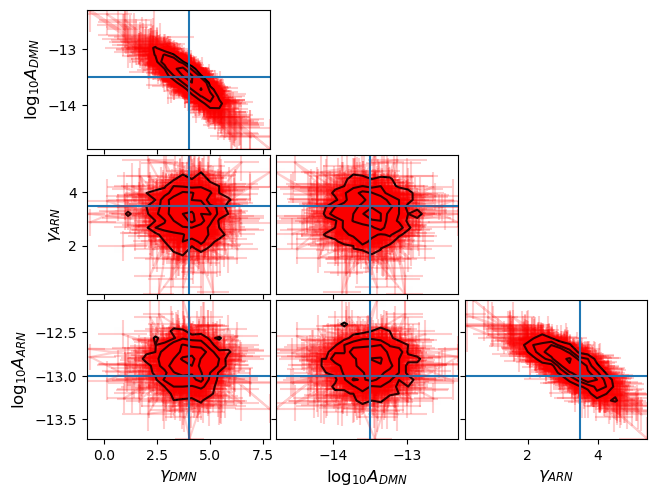

In [70]:
results = np.array(results)
true_values = [m0.TNDMGAM.value, m0.TNDMAMP.value, m0.TNREDGAM.value, m0.TNREDAMP.value]
labels = [
    "$\\gamma_{DMN}$",
    "$\\log_{10} A_{DMN}$",
    "$\\gamma_{ARN}$",
    "$\\log_{10} A_{ARN}$"
]



# for jj in range(4):
#     for ii in range(0, jj):
#         plt.subplot(4, 4,  4*ii + jj)

#         xval = results[:,2*ii]
#         xerr = results[:,2*ii+1]
#         yval = results[:,2*jj]
#         yerr = results[:,2*jj+1]

#         plt.errorbar(x=xval, y=yval, xerr=xerr, yerr=yerr, color="red", alpha=0.2)
#         corner.hist2d(xval, yval, smooth=0.1)
#         plt.axvline(true_values[ii])
#         plt.axhline(true_values[jj])

#         if ii == 0:
#             plt.ylabel(labels[jj])
        
#         if jj == 3:
#             plt.xlabel(labels[ii])


plt.subplot(331)
plt.errorbar(x=results[:,0], y=results[:,2], xerr=results[:,1], yerr=results[:,3], color="red", alpha=0.2)
corner.hist2d(results[:,0], results[:,2], smooth=0.3)
plt.axvline(true_values[0])
plt.axhline(true_values[1])
plt.ylabel(labels[1], fontsize=12)
plt.tick_params(labelbottom=False, axis="both", labelsize=10)


plt.subplot(334)
plt.errorbar(x=results[:,0], y=results[:,4], xerr=results[:,1], yerr=results[:,5], color="red", alpha=0.2)
corner.hist2d(results[:,0], results[:,4], smooth=0.3)
plt.axvline(true_values[0])
plt.axhline(true_values[2])
plt.ylabel(labels[2], fontsize=12)
plt.tick_params(labelbottom=False, axis="both", labelsize=10)

plt.subplot(335)
plt.errorbar(x=results[:,2], y=results[:,4], xerr=results[:,3], yerr=results[:,5], color="red", alpha=0.2)
corner.hist2d(results[:,2], results[:,4], smooth=0.3)
plt.axvline(true_values[1])
plt.axhline(true_values[2])
plt.tick_params(labelbottom=False, labelleft=False, axis="both", labelsize=10)

plt.subplot(337)
plt.errorbar(x=results[:,0], y=results[:,6], xerr=results[:,1], yerr=results[:,7], color="red", alpha=0.2)
corner.hist2d(results[:,0], results[:,6], smooth=0.3)
plt.axvline(true_values[0])
plt.axhline(true_values[3])
plt.ylabel(labels[3], fontsize=12)
plt.xlabel(labels[0], fontsize=12)
plt.tick_params(axis="both", labelsize=10)

plt.subplot(338)
plt.errorbar(x=results[:,2], y=results[:,6], xerr=results[:,3], yerr=results[:,7], color="red", alpha=0.2)
corner.hist2d(results[:,2], results[:,6], smooth=0.3)
plt.axvline(true_values[1])
plt.axhline(true_values[3])
plt.xlabel(labels[1], fontsize=12)
plt.tick_params(labelleft=False, axis="both", labelsize=10)

plt.subplot(339)
plt.errorbar(x=results[:,4], y=results[:,6], xerr=results[:,5], yerr=results[:,7], color="red", alpha=0.2)
corner.hist2d(results[:,4], results[:,6], smooth=0.3)
plt.axvline(true_values[2])
plt.axhline(true_values[3])
plt.xlabel(labels[2], fontsize=12)
plt.tick_params(labelleft=False, axis="both", labelsize=10)

plt.tight_layout(pad=0.1)

plt.savefig("sim5-multisim.pdf")

In [61]:
plt.tight_layout?

Signature: plt.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)
Docstring:
Adjust the padding between and around subplots.

To exclude an artist on the Axes from the bounding box calculation
that determines the subplot parameters (i.e. legend, or annotation),
set ``a.set_in_layout(False)`` for that artist.

Parameters
----------
pad : float, default: 1.08
    Padding between the figure edge and the edges of subplots,
    as a fraction of the font size.
h_pad, w_pad : float, default: *pad*
    Padding (height/width) between edges of adjacent subplots,
    as a fraction of the font size.
rect : tuple (left, bottom, right, top), default: (0, 0, 1, 1)
    A rectangle in normalized figure coordinates into which the whole
    subplots area (including labels) will fit.

See Also
--------
.Figure.set_tight_layout
.pyplot.tight_layout
File:      ~/miniconda3/envs/pint-noise/lib/python3.9/site-packages/matplotlib/pyplot.py
Type:      function